In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string

In [3]:
train = pd.read_csv("C:/Users/mkkma/Downloads/train.csv")
test = pd.read_csv("C:/Users/mkkma/Downloads//test.csv")

In [4]:
print (train.shape, test.shape)

(7613, 5) (3263, 4)


A quick look at our data
Let's look at our data... first, an example of what is NOT a disaster tweet.


In [5]:
train[train["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [6]:
train[train["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

Text(0, 0.5, 'samples')

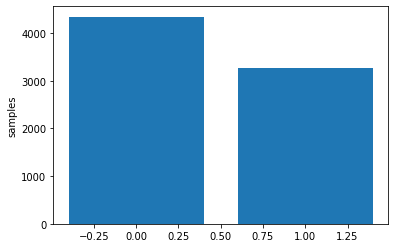

In [7]:
x=train.target.value_counts()
plt.bar(x.index,x)
plt.ylabel('samples')

There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

First,we will do very basic analysis,that is character level,word level and sentence level analysis.

**Number of characters in tweets**

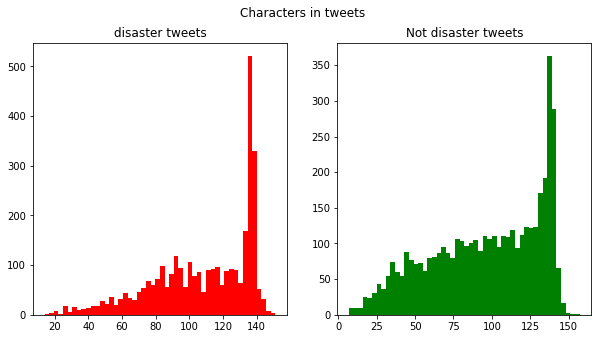

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color = 'red', bins = 50)
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color = 'green', bins = 50)
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distributions seem very similar, both seem to have 125 to 140 characters

**Number of words in a tweet**

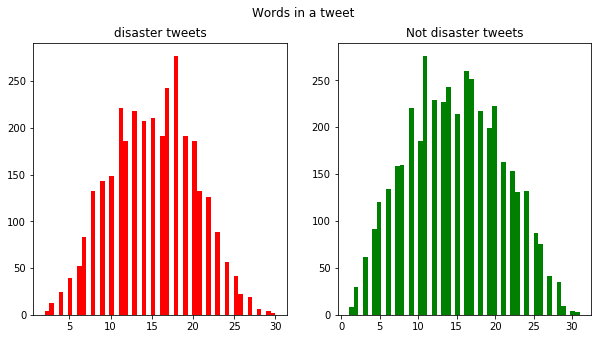

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red', bins =50)
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green', bins =50)
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Not much can be infered from the plots above.

We will now try to clean the data

In [10]:
df=pd.concat([train,test])
df.shape

C:\Users\mkkma\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

In [11]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [12]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [13]:
!pip install pyspellchecker



In [14]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        


In [15]:
from tqdm import tqdm

In [16]:
df['text']=df['text'].apply(lambda x : correct_spellings(x))

KeyboardInterrupt: 

### Summary of cleaning above:

1. URL removed
2. !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ removed
3. Spellings corrected

### In the section below following steps are performed

1. Lemmatisation
2. Stop words removal
3. tf-idf

In [17]:

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [18]:
df.head()

,id,keyword,location,target,text
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,1.0,All residents asked to shelter in place are be...
3,6,NaN,NaN,1.0,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby Alaska as s...


In [19]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

In [21]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [22]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [23]:
df['Lemmatize'] = df['text'].apply(lambda x: lemmatize_sentence(x))
print(df.head())

   id keyword location  target  \
0   1     NaN      NaN     1.0   
1   4     NaN      NaN     1.0   
2   5     NaN      NaN     1.0   
3   6     NaN      NaN     1.0   
4   7     NaN      NaN     1.0   

                                                text  \
0  Our Deeds are the Reason of this earthquake Ma...   
1              Forest fire near La Ronge Sask Canada   
2  All residents asked to shelter in place are be...   
3  13000 people receive wildfires evacuation orde...   
4  Just got sent this photo from Ruby Alaska as s...   

                                           Lemmatize  
0  Our Deeds be the Reason of this earthquake May...  
1              Forest fire near La Ronge Sask Canada  
2  All resident ask to shelter in place be be not...  
3  13000 people receive wildfire evacuation order...  
4  Just get send this photo from Ruby Alaska as s...  


In [26]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [27]:
df['lemmatize_without_stopwords'] = df['Lemmatize'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,id,keyword,location,target,text,Lemmatize,lemmatize_without_stopwords
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this earthquake Ma...,Our Deeds be the Reason of this earthquake May...,Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,1.0,All residents asked to shelter in place are be...,All resident ask to shelter in place be be not...,All resident ask shelter place notify officer ...
3,6,NaN,NaN,1.0,13000 people receive wildfires evacuation orde...,13000 people receive wildfire evacuation order...,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby Alaska as s...,Just get send this photo from Ruby Alaska as s...,Just get send photo Ruby Alaska smoke wildfire...


In [28]:
#Dropping columns text and lemmatize
df.drop(['text','Lemmatize'],axis = 1,inplace = True)

In [29]:
df.head()

,id,keyword,location,target,lemmatize_without_stopwords
0,1,NaN,NaN,1.0,Our Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,1.0,All resident ask shelter place notify officer ...
3,6,NaN,NaN,1.0,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,1.0,Just get send photo Ruby Alaska smoke wildfire...


In [31]:
df.to_csv('Final_PA2_data.csv' ,index =False)